In [1]:
src_name='Crab'
name1='1A 0535+262'
ra=83.633080
dec=22.014500
radius=15.
radius_jemx=5.
T1_utc='2003-03-15T23:27:40.0'
T2_utc='2018-03-16T00:03:15.0'
E1_keV=20.
E2_keV=40.
E1_keV_jemx=3.
E2_keV_jemx=20.

rebin=10

In [2]:
import numpy as np
ebins=np.logspace(0,5,26)
print(ebins)

[1.00000000e+00 1.58489319e+00 2.51188643e+00 3.98107171e+00
 6.30957344e+00 1.00000000e+01 1.58489319e+01 2.51188643e+01
 3.98107171e+01 6.30957344e+01 1.00000000e+02 1.58489319e+02
 2.51188643e+02 3.98107171e+02 6.30957344e+02 1.00000000e+03
 1.58489319e+03 2.51188643e+03 3.98107171e+03 6.30957344e+03
 1.00000000e+04 1.58489319e+04 2.51188643e+04 3.98107171e+04
 6.30957344e+04 1.00000000e+05]


In [3]:
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os
from astropy.io import fits
import numpy as np
from numpy import sqrt,exp
%matplotlib notebook
import matplotlib.pyplot as plt

host='https://www.astro.unige.ch/cdci/astrooda/dispatch-data'
disp=DispatcherAPI(host=host)

In [4]:
image_catalog=disp.get_product(instrument='isgri',
                      product='isgri_image',
                      T1='2003-03-15T23:27:40.0',
                      T2='2015-03-16T00:03:15.0',
                      radius=radius,
                      E1_keV=E1_keV,
                      E2_keV=E2_keV,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=10,
                      product_type='Real')
        

- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2003-03-15T23:27:40.0
T2 2015-03-16T00:03:15.0
radius 15.0
E1_keV 20.0
E2_keV 40.0
osa_version OSA10.2
RA 83.63308
DEC 22.0145
detection_threshold 10
instrument isgri
product_type isgri_image
query_type Real
off_line (False,)
query_status ('new',)
verbose (False,)
session_id PB1UY313UQHWOLRI
dry_run (False,)
api True
oda_api_version 1.0.1


query done succesfully!


In [5]:
image_catalog.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str11,float64,float64,float64,int64,int64,int64,float64
0,1A 0535+262,125.4826889038086,84.72280883789062,26.312734603881836,-32768,2,0,0.0002800000074785203
7,Crab,1358.7255859375,83.63166809082031,22.016284942626953,-32768,2,0,0.0002800000074785203
8,H 0614+091,12.993664741516113,94.27821350097656,9.141680717468262,-32768,2,0,0.0002800000074785203
48,Crab,142.5009002685547,83.63369750976562,22.013002395629883,-32768,2,0,0.0002800000074785203


In [6]:
image_catalog.dispatcher_catalog_1.table.remove_rows([2,3])

In [7]:
image_catalog.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str11,float64,float64,float64,int64,int64,int64,float64
0,1A 0535+262,125.4826889038086,84.72280883789062,26.312734603881836,-32768,2,0,0.0002800000074785203
7,Crab,1358.7255859375,83.63166809082031,22.016284942626953,-32768,2,0,0.0002800000074785203


In [8]:
api_cat=image_catalog.dispatcher_catalog_1.get_api_dictionary()

In [9]:
lc=disp.get_product(instrument='isgri',
                    product='isgri_lc',
                    T1=T1_utc,
                    T2=T2_utc,
                    radius=radius,
                    query_type='Real',
                    osa_version='OSA10.2',
                    RA=ra,
                    DEC=dec,
                    product_type='Real',
                    selected_catalog=api_cat)



- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2003-03-15T23:27:40.0
T2 2018-03-16T00:03:15.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U11"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "<f8"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}
instrument isgri
product_type isgri_lc
off_line (False,)
query_status ('new'

In [10]:
t=[]
r=[]
err=[]
tot_counts=[]
backv=[]
backe=[]
i=0
for ID,s in enumerate(lc._p_list):
    if s.meta_data['src_name']==src_name:
        i=i+1
        for tt in s.data_unit[1].data['TIME']:
            t.append(tt)
        for rr in s.data_unit[1].data['RATE']:
            r.append(rr)
        for ee in s.data_unit[1].data['ERROR']:
            err.append(ee)
        for tc in s.data_unit[1].data['TOT_COUNTS']:
            tot_counts.append(tc)
        for bv in s.data_unit[1].data['BACKV']:
            backv.append(bv)
        for be in s.data_unit[1].data['BACKE']:
            backe.append(be)
t=np.array(t)
r=np.array(r)
err=np.array(err)
tot_counts=np.array(tot_counts)
backv=np.array(backv)
backe=np.array(backe)

t1=[]
r1=[]
err1=[]
tot_counts1=[]
backv1=[]
backe1=[]
i=0
for ID,s in enumerate(lc._p_list):
    if s.meta_data['src_name']==name1:
        i=i+1
        for tt in s.data_unit[1].data['TIME']:
            t1.append(tt)
        for rr in s.data_unit[1].data['RATE']:
            r1.append(rr)
        for ee in s.data_unit[1].data['ERROR']:
            err1.append(ee)
        for tc in s.data_unit[1].data['TOT_COUNTS']:
            tot_counts1.append(tc)
        for bv in s.data_unit[1].data['BACKV']:
            backv1.append(bv)
        for be in s.data_unit[1].data['BACKE']:
            backe1.append(be)
t1=np.array(t1)
r1=np.array(r1)
err1=np.array(err1)
tot_counts1=np.array(tot_counts1)
backv1=np.array(backv1)
backe1=np.array(backe1)



<IPython.core.display.Javascript object>


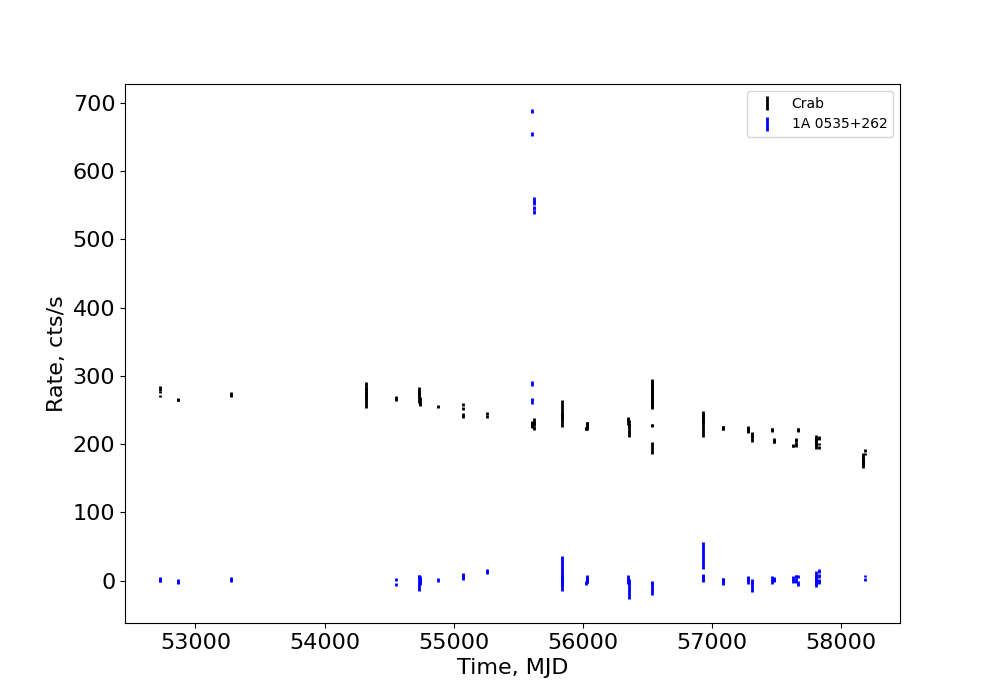

In [11]:
fig = plt.figure(figsize=(10,7))
t0=51544
plt.errorbar(t+t0,r,yerr=err,linestyle='none',color='black',alpha=1,linewidth=2, label='Crab')
plt.errorbar(t1+t0,r1,yerr=err1,linestyle='none',color='blue',alpha=1,linewidth=2, label=name1)

plt.tick_params(axis='both', which='major', labelsize=16)
ymax=1.2*max(r+err)
ymin=0.5*max(r-err)

tmin=t[0]+t0
tmax=t[-1]+t0
#plt.ylim(ymin,ymax)
#plt.xlim(55297,55298)
plt.xlabel('Time, MJD',fontsize=16)
plt.ylabel('Rate, cts/s',fontsize=16)
#plt.text(tmin,0.95*ymax, str(E1_keV)+'-'+str(E2_keV)+' keV',fontsize=16)
#plt.text(tmin,0.9*ymax, src_name,fontsize=16)

name=src_name.replace(" ", "")
plt.legend()
plt.savefig(name+'_lc_50scws.pdf',format='pdf',dpi=100)

In [12]:
image_catalog_jemx=disp.get_product(instrument='jemx',
                      jemx_num=1,
                      product='jemx_image',
                      T1=T1_utc,
                      T2=T2_utc,
                      radius=radius_jemx,
                      E1_keV=E1_keV_jemx,
                      E2_keV=E2_keV_jemx,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=10,
                      product_type='Real')

- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
jemx_num 1
T1 2003-03-15T23:27:40.0
T2 2018-03-16T00:03:15.0
radius 5.0
E1_keV 3.0
E2_keV 20.0
osa_version OSA10.2
RA 83.63308
DEC 22.0145
detection_threshold 10
instrument jemx
product_type jemx_image
query_type Real
off_line (False,)
query_status ('new',)
verbose (False,)
session_id B2Q58DURYLI2FTS7
dry_run (False,)
api True
oda_api_version 1.0.1


query done succesfully!


In [13]:
image_catalog_jemx.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,FLAG,ERR_RAD
,,,deg,deg,,
int64,str11,float64,float64,float64,int64,float64
0,Crab,1071.6285400390625,83.63072967529297,22.017940521240234,0,0.05000000074505806
1,1A 0535+262,34.18019104003906,84.73592376708984,26.314897537231445,0,0.05000000074505806


In [14]:
#image_catalog_jemx.dispatcher_catalog_1.table.remove_rows([2,3,4])

In [15]:
image_catalog_jemx.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,FLAG,ERR_RAD
,,,deg,deg,,
int64,str11,float64,float64,float64,int64,float64
0,Crab,1071.6285400390625,83.63072967529297,22.017940521240234,0,0.05000000074505806
1,1A 0535+262,34.18019104003906,84.73592376708984,26.314897537231445,0,0.05000000074505806


In [16]:
api_cat_jemx=image_catalog_jemx.dispatcher_catalog_1.get_api_dictionary()

In [17]:
spectrum_results_jemx=[]

for i in range(2004,2020):
    T1_utc=str(i)+'-01-01T00:00:00.0'
    T2_utc=str(i)+'-12-31T23:59:59.0'
        
    print(T1_utc,'-',T2_utc)
    if i<2016:
        osa_version='OSA10.2'
    else:
        osa_version='OSA11.0'
    data=disp.get_product(instrument='jemx',
                        jemx_num=1,
                        product='jemx_spectrum',
                        T1=T1_utc,
                        T2=T2_utc,
                        radius=radius_jemx,
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat_jemx)
    
    spectrum_results_jemx.append(data)



2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
jemx_num 1
T1 2004-01-01T00:00:00.0
T2 2004-12-31T23:59:59.0
radius 5.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 1], ["Crab", "1A 0535+262"], [1071.6285400390625, 34.18019104003906], [83.63072967529297, 84.73592376708984], [22.017940521240234, 26.314897537231445], [0, 0], [0.05000000074505806, 0.05000000074505806]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U11"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["FLAG", "<i8"], ["ERR_RAD", "<f8"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}
instrument jemx
product_type jemx_spectrum
off_line (False,)
query_status ('new',)
verbose (False,)
session_id DLGHDPUAFJ



query done succesfully!
2012-01-01T00:00:00.0 - 2012-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
jemx_num 1
T1 2012-01-01T00:00:00.0
T2 2012-12-31T23:59:59.0
radius 5.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 1], ["Crab", "1A 0535+262"], [1071.6285400390625, 34.18019104003906], [83.63072967529297, 84.73592376708984], [22.017940521240234, 26.314897537231445], [0, 0], [0.05000000074505806, 0.05000000074505806]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U11"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["FLAG", "<i8"], ["ERR_RAD", "<f8"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}
instrument jemx
product_type jemx_spectrum
off_line (False,)
query_status ('new',)
verbose (Fal

the job has been submitted on the remote server
 - the job is working remotely, please wait status=done - job_id=-3043510501402920963  63  

query done succesfully!


In [18]:
i=2003
for data in spectrum_results_jemx:
    print(i)
    for ID,s in enumerate(data._p_list):
        if (s.meta_data['src_name']==src_name):
            if(s.meta_data['product']=='jemx_spectrum'):
                ID_spec_jemx1=ID
            if(s.meta_data['product']=='jemx_arf'):
                ID_arf_jemx1=ID
            if(s.meta_data['product']=='jemx_rmf'):
                ID_rmf_jemx1=ID

    print(i+2003, ID_spec_jemx1, ID_arf_jemx1, ID_rmf_jemx1)
    name=src_name+'_'+str(i)

    specname_jemx1=name+'_spectrum_osa10_jemx1.fits'
    arfname_jemx1=name+'_arf_osa10_jemx1.fits.gz'
    rmfname_jemx1=name+'_rmf_osa10_jemx1.fits.gz'
    data._p_list[ID_spec_jemx1].write_fits_file(specname_jemx1)
    data._p_list[ID_arf_jemx1].write_fits_file(arfname_jemx1)
    data._p_list[ID_rmf_jemx1].write_fits_file(rmfname_jemx1)
    i+=1



2003
4006 3 4 5


2004
4007 3 4 5
2005
4008 3 4 5
2006
4009 3 4 5
2007
4010 3 4 5
2008
4011 3 4 5
2009
4012 3 4 5
2010
4013 3 4 5
2011
4014 3 4 5
2012
4015 3 4 5
2013
4016 3 4 5
2014
4017 3 4 5
2015
4018 3 4 5
2016
4019 3 4 5
2017
4020 3 4 5
2018
4021 3 4 5


In [19]:
spectrum_results=[]

for i in range(2004,2020):
    T1_utc=str(i)+'-01-01T00:00:00.0'
    T2_utc=str(i)+'-12-31T23:59:59.0'
    
    print(T1_utc,'-',T2_utc)
    if i<2016:
        osa_version='OSA10.2'
    else:
        osa_version='OSA11.0'
    data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        T1=T1_utc,
                        T2=T2_utc,
                        radius=radius,
                        query_type='Real',
                        osa_version=osa_version,
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat)
    for ID,s in enumerate(data._p_list):
        if (s.meta_data['src_name']==src_name):
            if(s.meta_data['product']=='isgri_spectrum'):
                ID_spec=ID
            if(s.meta_data['product']=='isgri_arf'):
                ID_arf=ID
            if(s.meta_data['product']=='isgri_rmf'):
                ID_rmf=ID

    print(ID_spec, ID_arf, ID_rmf)
    spec=data._p_list[ID_spec].data_unit[1].data
    arf=data._p_list[ID_arf].data_unit[1].data
    rmf=data._p_list[ID_rmf].data_unit[2].data
    expos=data._p_list[0].data_unit[1].header['EXPOSURE']
    name=src_name+'_'+str(i)
    specname=name+'_spectrum_osa10.fits'
    arfname=name+'_arf_osa10.fits.gz'
    rmfname=name+'_rmf_osa10.fits.gz'
    data._p_list[ID_spec].write_fits_file(specname)
    data._p_list[ID_arf].write_fits_file(arfname)
    data._p_list[ID_rmf].write_fits_file(rmfname)
    hdul = fits.open(specname, mode='update')
    hdr=hdul[1].header
    hdr.set('EXPOSURE', expos)
    hdul.close()
    !./spectrum_fit_osa10_isgri_jemx1.sh $name $rebin
    
    spectrum_results.append(data)


2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2004-01-01T00:00:00.0
T2 2004-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U11"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "<f8"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}
instrument isgri
product_type 

 Spectrum Number: 1
 Model Flux   0.18912 photons (2.2386e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.15685 photons (1.2843e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2004_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2005-01-01T00:00:00.0
T2 2005-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", 

 Spectrum Number: 1
 Model Flux   0.18417 photons (2.0871e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.12475 photons (1.0082e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2005_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2006-01-01T00:00:00.0
T2 2006-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", 

XSPEC12>flux 30. 300.
 Spectrum Number: 1
 Data Group Number: 1
 Model Flux   0.19138 photons (2.2625e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
Spectrum 2: Upper range bound          300 reset by matrix bound to      100.391
 Spectrum Number: 2
 Data Group Number: 2
 Model Flux    0.1436 photons (1.1753e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>flux error
Spectrum 2: Upper range bound          300 reset by matrix bound to      100.391
Parameter distribution is derived from fit covariance matrix.
 Spectrum Number: 1
 Model Flux   0.19138 photons (2.2625e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux    0.1436 photons (1.1753e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2006_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2007-01-01T00:00:00.0 - 2007-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch

 Spectrum Number: 1
 Model Flux    0.1943 photons (2.3093e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.16345 photons (1.3399e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2007_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2008-01-01T00:00:00.0 - 2008-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2008-01-01T00:00:00.0
T2 2008-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", 

 Spectrum Number: 1
 Model Flux   0.19022 photons (2.2536e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.15585 photons (1.2764e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2008_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2009-01-01T00:00:00.0 - 2009-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2009-01-01T00:00:00.0
T2 2009-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", 

 Spectrum Number: 1
 Model Flux    0.1897 photons (2.242e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.15464 photons (1.2656e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2009_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2010-01-01T00:00:00.0 - 2010-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2010-01-01T00:00:00.0
T2 2010-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "

 Spectrum Number: 1
 Model Flux   0.18881 photons (2.2304e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux    0.1583 photons (1.2953e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2010_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2011-01-01T00:00:00.0 - 2011-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2011-01-01T00:00:00.0
T2 2011-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", 

 Spectrum Number: 1
 Model Flux   0.18615 photons (2.2022e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.15359 photons (1.2574e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2011_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2012-01-01T00:00:00.0 - 2012-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2012-01-01T00:00:00.0
T2 2012-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", 

 Spectrum Number: 1
 Model Flux    0.1889 photons (2.2315e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.15269 photons (1.2494e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2012_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2013-01-01T00:00:00.0 - 2013-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2013-01-01T00:00:00.0
T2 2013-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", 

 Spectrum Number: 1
 Model Flux   0.19032 photons (2.2412e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.15241 photons (1.246e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2013_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2014-01-01T00:00:00.0 - 2014-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2014-01-01T00:00:00.0
T2 2014-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "

 Spectrum Number: 1
 Model Flux   0.18915 photons (2.2354e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.15052 photons (1.2319e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2014_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2015-01-01T00:00:00.0 - 2015-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2015-01-01T00:00:00.0
T2 2015-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", 

 Spectrum Number: 1
 Model Flux   0.19103 photons (2.257e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux     0.147 photons (1.203e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2015_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2016-01-01T00:00:00.0 - 2016-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2016-01-01T00:00:00.0
T2 2016-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA11.0
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "d

 Spectrum Number: 1
 Model Flux   0.18734 photons (2.1824e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.13415 photons (1.0932e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2016_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2017-01-01T00:00:00.0 - 2017-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2017-01-01T00:00:00.0
T2 2017-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA11.0
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", 

 Spectrum Number: 1
 Model Flux   0.17564 photons (2.0541e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.13242 photons (1.0803e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2017_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2018-01-01T00:00:00.0 - 2018-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2018-01-01T00:00:00.0
T2 2018-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA11.0
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", 

 Spectrum Number: 1
 Model Flux   0.18933 photons (2.2036e-08 ergs/cm^2/s) range (30.000 - 300.00 keV)
 Spectrum Number: 2
 Model Flux   0.13165 photons (1.0725e-08 ergs/cm^2/s) range (30.000 - 100.39 keV)
XSPEC12>setplot rebin 10 10
XSPEC12>plot eeufs
XSPEC12>iplot
PLT> wdata Crab_2018_spectrum_osa10.txt
PLT> XSPEC12>
 XSPEC: quit
2019-01-01T00:00:00.0 - 2019-12-31T23:59:59.0
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2019-01-01T00:00:00.0
T2 2019-12-31T23:59:59.0
radius 15.0
query_type Real
osa_version OSA11.0
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", 

<IPython.core.display.Javascript object>


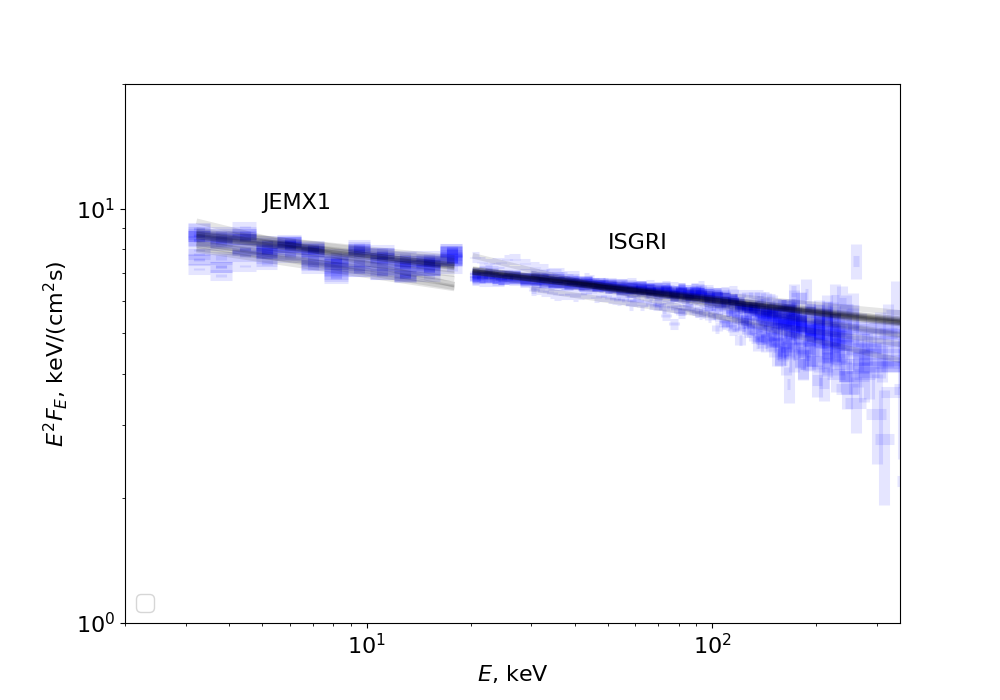

No handles with labels found to put in legend.


In [21]:
plt.figure(figsize=(10,7))

for i in range(2004,2019):
    name=src_name+'_'+str(i)
    spectrum=np.genfromtxt(name+'_spectrum_osa10.txt',skip_header=3)
    en=spectrum[:,0]
    en_err=spectrum[:,1]
    fl=spectrum[:,2]
    fl_err=spectrum[:,3]
    mo=spectrum[:,4]
    plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='blue',alpha=0.1)
    plt.plot(en,mo,color='black',linewidth=4,alpha=0.1)


plt.tick_params(axis='both', which='major', labelsize=16)
plt.text(5,10,'JEMX1',fontsize=16)
plt.text(50,8,'ISGRI',fontsize=16)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1,20.)
plt.xlim(2,350)
plt.xlabel('$E$, keV',fontsize=16)
plt.ylabel('$E^2F_E$, keV/(cm$^2$s)',fontsize=16)
plt.legend(loc='lower left',fontsize=16)
plt.savefig(src_name+'_spectrum1.pdf',format='pdf',dpi=100)


In [22]:
T1_utc='2010-04-01T00:00:00'
T2_utc='2010-04-21T00:00:00'
lc=disp.get_product(instrument='isgri',
                    product='isgri_lc',
                    T1=T1_utc,
                    T2=T2_utc,
                    query_type='Real',
                    osa_version='OSA10.2',
                    RA=ra,
                    DEC=dec,
                    product_type='Real',
                    selected_catalog=api_cat)



- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2010-04-01T00:00:00
T2 2010-04-21T00:00:00
query_type Real
osa_version OSA10.2
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U11"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "<f8"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}
instrument isgri
product_type isgri_lc
off_line (False,)
query_status ('new',)
verbose (Fals

In [23]:
t=[]
r=[]
err=[]
tot_counts=[]
backv=[]
backe=[]
i=0
for ID,s in enumerate(lc._p_list):
    if s.meta_data['src_name']==src_name:
        i=i+1
        for tt in s.data_unit[1].data['TIME']:
            t.append(tt)
        for rr in s.data_unit[1].data['RATE']:
            r.append(rr)
        for ee in s.data_unit[1].data['ERROR']:
            err.append(ee)
        for tc in s.data_unit[1].data['TOT_COUNTS']:
            tot_counts.append(tc)
        for bv in s.data_unit[1].data['BACKV']:
            backv.append(bv)
        for be in s.data_unit[1].data['BACKE']:
            backe.append(be)
t=np.array(t)
r=np.array(r)
err=np.array(err)
tot_counts=np.array(tot_counts)
backv=np.array(backv)
backe=np.array(backe)

t1=[]
r1=[]
err1=[]
tot_counts1=[]
backv1=[]
backe1=[]
i=0
for ID,s in enumerate(lc._p_list):
    if s.meta_data['src_name']==name1:
        i=i+1
        for tt in s.data_unit[1].data['TIME']:
            t1.append(tt)
        for rr in s.data_unit[1].data['RATE']:
            r1.append(rr)
        for ee in s.data_unit[1].data['ERROR']:
            err1.append(ee)
        for tc in s.data_unit[1].data['TOT_COUNTS']:
            tot_counts1.append(tc)
        for bv in s.data_unit[1].data['BACKV']:
            backv1.append(bv)
        for be in s.data_unit[1].data['BACKE']:
            backe1.append(be)
t1=np.array(t1)
r1=np.array(r1)
err1=np.array(err1)
tot_counts1=np.array(tot_counts1)
backv1=np.array(backv1)
backe1=np.array(backe1)



<IPython.core.display.Javascript object>


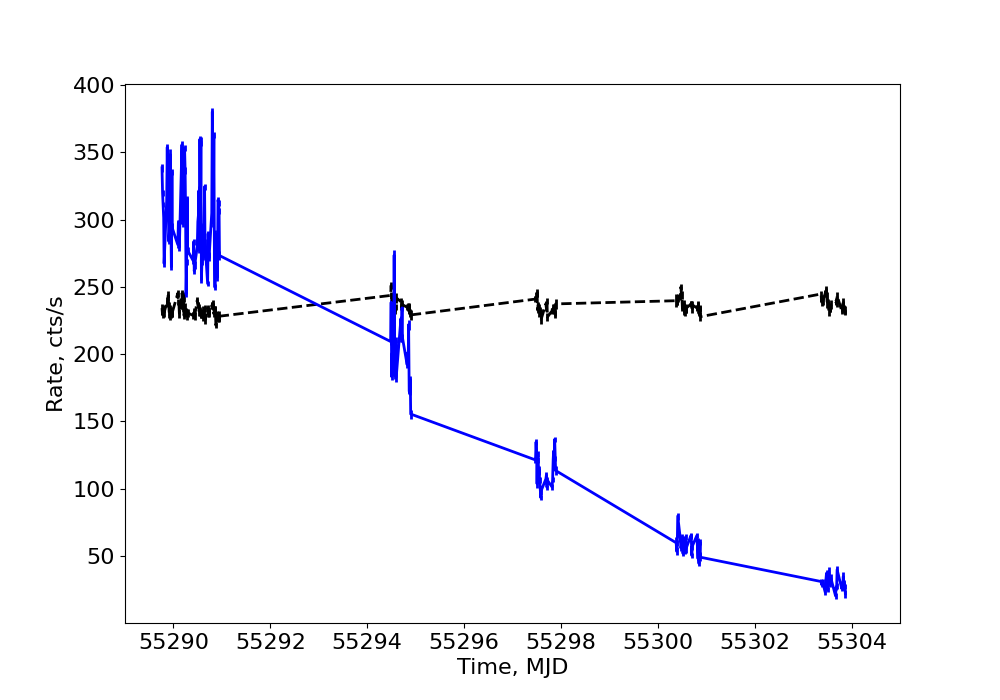

In [24]:
#special fix to a period when 1A 0535+262 was flaring:
fig = plt.figure(figsize=(10,7))
t0=51544
plt.errorbar(t+t0,r,yerr=err,linestyle='dashed',color='black',alpha=1,linewidth=2)
plt.errorbar(t1+t0,r1,yerr=err1,linestyle='solid',color='blue',alpha=1,linewidth=2)

plt.tick_params(axis='both', which='major', labelsize=16)
ymax=1.2*max(r+err)
ymin=0.5*max(r-err)

tmin=t[0]+t0
tmax=t[-1]+t0
#plt.ylim(ymin,ymax)
plt.xlim(55289,55305)
plt.xlabel('Time, MJD',fontsize=16)
plt.ylabel('Rate, cts/s',fontsize=16)
#plt.text(tmin,0.95*ymax, str(E1_keV)+'-'+str(E2_keV)+' keV',fontsize=16)
#plt.text(tmin,0.9*ymax, src_name,fontsize=16)

name=src_name.replace(" ", "")
plt.savefig(name+'_lc_50scws.pdf',format='pdf',dpi=100)

In [25]:
spectrum_1A0535_burst=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        T1='2010-04-03T00:00:00',
                        T2='2010-04-06T00:00:00',
                        query_type='Real',
                        osa_version=osa_version,
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat)

- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2010-04-03T00:00:00
T2 2010-04-06T00:00:00
query_type Real
osa_version OSA11.0
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 7], ["1A 0535+262", "Crab"], [125.4826889038086, 1358.7255859375], [84.72280883789062, 83.63166809082031], [26.312734603881836, 22.016284942626953], [-32768, -32768], [2, 2], [0, 0], [0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U11"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "<f8"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}
instrument isgri
product_type isgri_spectrum
off_line (False,)
query_status ('new',)
verbose

In [26]:
for ID,s in enumerate(spectrum_1A0535_burst._p_list):
    if (s.meta_data['src_name']==src_name):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)
spec=data._p_list[ID_spec].data_unit[1].data
arf=data._p_list[ID_arf].data_unit[1].data
rmf=data._p_list[ID_rmf].data_unit[2].data
expos=data._p_list[0].data_unit[1].header['EXPOSURE']
name=src_name+'_with1A0535'
specname=name+'_spectrum_osa10.fits'
arfname=name+'_arf_osa10.fits.gz'
rmfname=name+'_rmf_osa10.fits.gz'
data._p_list[ID_spec].write_fits_file(specname)
data._p_list[ID_arf].write_fits_file(arfname)
data._p_list[ID_rmf].write_fits_file(rmfname)
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', expos)
hdul.close()
!./spectrum_fit_osa10.sh $name $rebin



3 4 5



		XSPEC version: 12.10.1f
	Build Date/Time: Tue Apr 21 20:29:57 2020

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data Crab_with1A0535_spectrum_osa10.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: Crab_with1A0535_spectrum_osa10.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  -nan      +/- -nan     
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-256
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 3.83e+04 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response Crab_with1A0535_rmf_osa10.fits.gz
Response successfully loaded.
XSPEC12>arf Crab_with1A0535_arf_osa10.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:    25 chann

In [27]:
for ID,s in enumerate(spectrum_1A0535_burst._p_list):
    if (s.meta_data['src_name']==name1):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)
spec=data._p_list[ID_spec].data_unit[1].data
arf=data._p_list[ID_arf].data_unit[1].data
rmf=data._p_list[ID_rmf].data_unit[2].data
expos=data._p_list[0].data_unit[1].header['EXPOSURE']
name=name1+'_with1A0535'
specname=name+'_spectrum_osa10.fits'
arfname=name+'_arf_osa10.fits.gz'
rmfname=name+'_rmf_osa10.fits.gz'
data._p_list[ID_spec].write_fits_file(specname)
data._p_list[ID_arf].write_fits_file(arfname)
data._p_list[ID_rmf].write_fits_file(rmfname)
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', expos)
hdul.close()
!./spectrum_fit_osa10.sh $name $rebin



3 4 5

		XSPEC version: 12.10.1f
	Build Date/Time: Tue Apr 21 20:29:57 2020

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data 1A_spectrum_osa10.fits
Error: cannot read spectrum file 1A_spectrum_osa10.fits
a10.fits.gze ( "none" or "/*" to return to the XSPEC prompt): response 1A_rmf_os 
No such file: response 1A_rmf_osa10.fits.gz
its.gzlename ( "none" or "/*" to return to the XSPEC prompt): arf 1A_arf_osa10.f 
No such file: arf 1A_arf_osa10.fits.gz
New filename ( "none" or "/*" to return to the XSPEC prompt): ignore bad
terminated at user request
XSPEC12>ignore **-20.

***XSPEC Error:  no data loaded No such file: ignore bad.pha


XSPEC12>ignore 100.-**

***XSPEC Error:  no data loaded 

XSPEC12>model  pegpwrlw

Input parameter value, delta, min, bot, top, and max values for ...
              1       0.01(      0.01)         -3         -2          9         10
   10pwrlw:PhoIndex>         1.      

In [28]:
image_catalog.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str11,float64,float64,float64,int64,int64,int64,float64
0,1A 0535+262,125.4826889038086,84.72280883789062,26.312734603881836,-32768,2,0,0.0002800000074785203
7,Crab,1358.7255859375,83.63166809082031,22.016284942626953,-32768,2,0,0.0002800000074785203


In [29]:
image_catalog.dispatcher_catalog_1.table.remove_rows([0])


In [30]:
image_catalog.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str11,float64,float64,float64,int64,int64,int64,float64
7,Crab,1358.7255859375,83.63166809082031,22.016284942626953,-32768,2,0,0.0002800000074785203


In [31]:
api_cat=image_catalog.dispatcher_catalog_1.get_api_dictionary()

In [32]:
spectrum_1A0535_burst1=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        T1='2010-04-03T00:00:00',
                        T2='2010-04-06T00:00:00',
                        query_type='Real',
                        osa_version=osa_version,
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat)

- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2010-04-03T00:00:00
T2 2010-04-06T00:00:00
query_type Real
osa_version OSA11.0
RA 83.63308
DEC 22.0145
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[7], ["Crab"], [1358.7255859375], [83.63166809082031], [22.016284942626953], [-32768], [2], [0], [0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U11"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "<f8"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}
instrument isgri
product_type isgri_spectrum
off_line (False,)
query_status ('new',)
verbose (False,)
session_id XKKSGVVLTYM59KVX
dry_run (False,)
api True
oda_api_version 1.0.1


query done succesfully!


In [33]:
for ID,s in enumerate(spectrum_1A0535_burst1._p_list):
    if (s.meta_data['src_name']==src_name):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)
spec=data._p_list[ID_spec].data_unit[1].data
arf=data._p_list[ID_arf].data_unit[1].data
rmf=data._p_list[ID_rmf].data_unit[2].data
expos=data._p_list[0].data_unit[1].header['EXPOSURE']
name=src_name+'_without1A0535'
specname=name+'_spectrum_osa10.fits'
arfname=name+'_arf_osa10.fits.gz'
rmfname=name+'_rmf_osa10.fits.gz'
data._p_list[ID_spec].write_fits_file(specname)
data._p_list[ID_arf].write_fits_file(arfname)
data._p_list[ID_rmf].write_fits_file(rmfname)
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', expos)
hdul.close()
!./spectrum_fit_osa10.sh $name $rebin




3 4 5

		XSPEC version: 12.10.1f
	Build Date/Time: Tue Apr 21 20:29:57 2020

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data Crab_without1A0535_spectrum_osa10.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: Crab_without1A0535_spectrum_osa10.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  -nan      +/- -nan     
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-256
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 3.83e+04 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response Crab_without1A0535_rmf_osa10.fits.gz
Response successfully loaded.
XSPEC12>arf Crab_without1A0535_arf_osa10.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

i

<IPython.core.display.Javascript object>


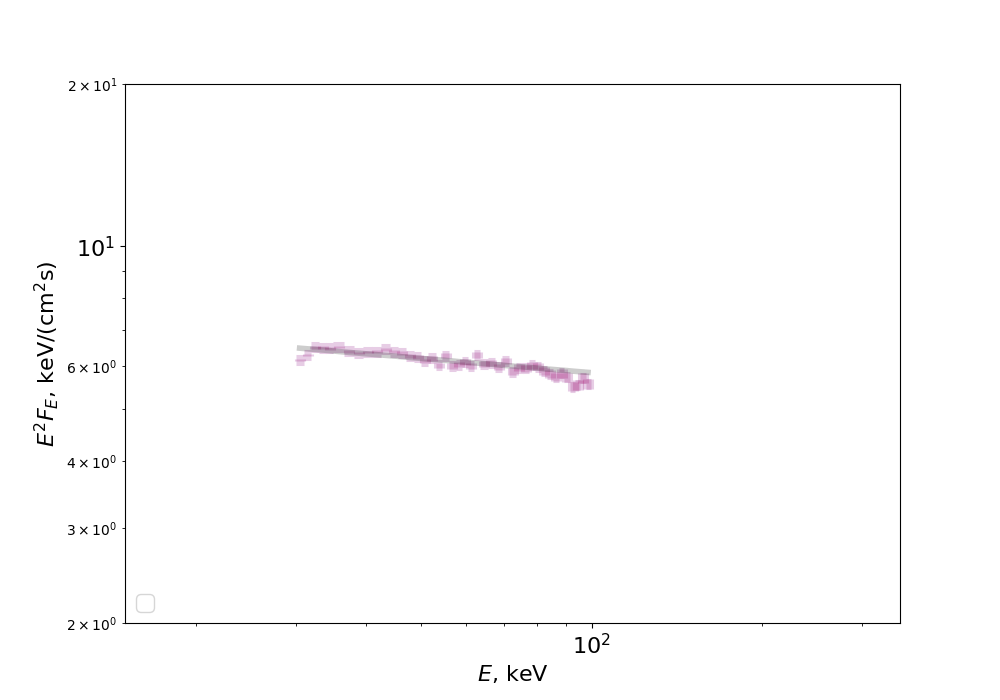

No handles with labels found to put in legend.


In [34]:
plt.figure(figsize=(10,7))

name=src_name+'_with1A0535'
spectrum=np.genfromtxt(name+'_spectrum_osa10.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='blue',alpha=0.1)
plt.plot(en,mo,color='black',linewidth=4,alpha=0.1)
name=src_name+'_without1A0535'
spectrum=np.genfromtxt(name+'_spectrum_osa10.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='red',alpha=0.1)
plt.plot(en,mo,color='black',linewidth=4,alpha=0.1)



plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(2,20.)
plt.xlim(15,350)
plt.xlabel('$E$, keV',fontsize=16)
plt.ylabel('$E^2F_E$, keV/(cm$^2$s)',fontsize=16)
plt.legend(loc='lower left',fontsize=16)
plt.savefig(src_name+'_spectrum.pdf',format='pdf',dpi=100)

